# Game of Thrones NLP-Neural Network Project

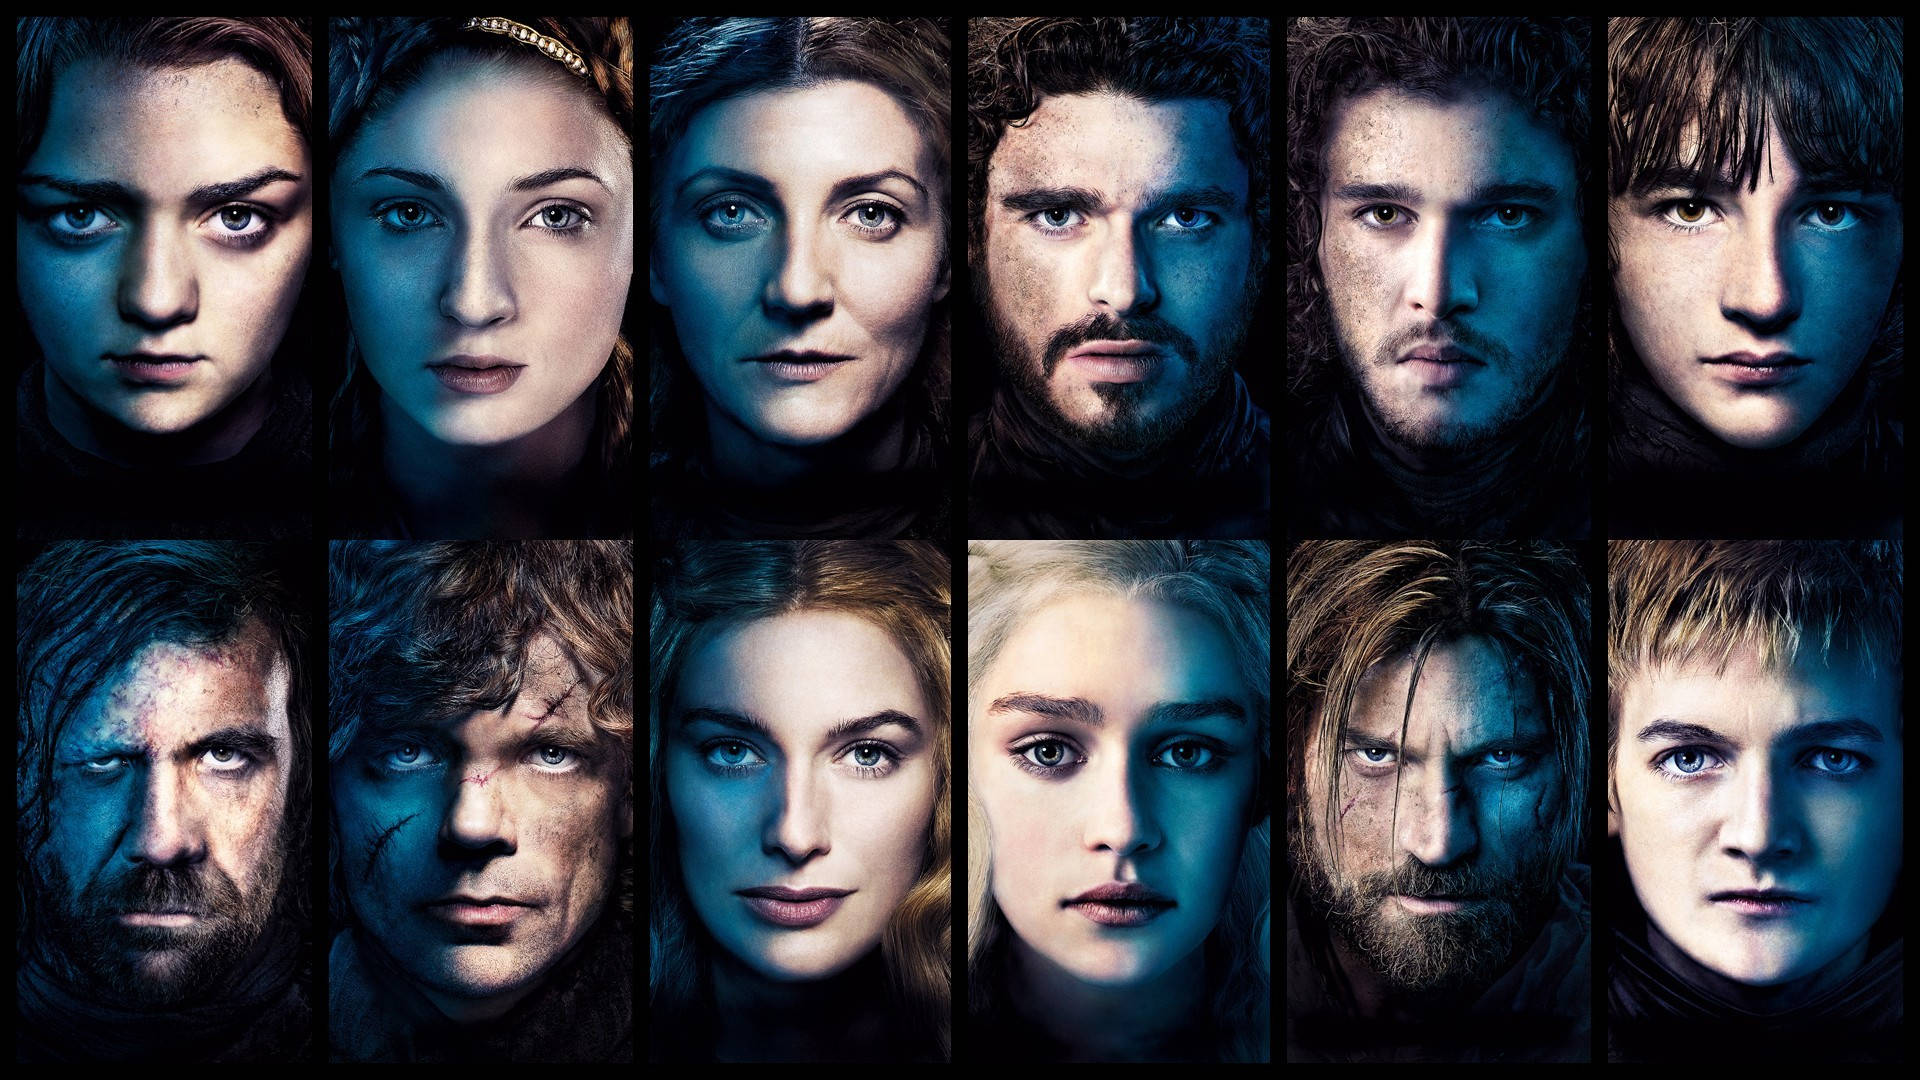

## Table of Content

* [Intro](#Intro)
* [Import Libraries](#Part-1:-Import-Libraries)
* [Data Scraping](#Part-2:-Scrape-the-Internet-for-List-of-All-Characters)
* [Set Up Data Sources](#Part-3:-Acquire-and-Set-Up-the-Proper-Data-Sources)
* [Data Wrangling](#Part-4:-Data-Cleaning-and-Preparation)
* [Visualization and Analysis](#Part-5:-Visualization-and-Analysis)
* [Conclusions](#Conclusions)
* [Shortcomings and Potential Improvements](#Shortcomings-and-Potential-Improvements)

## Intro

A Song of Ice and Fire(ASOIAF) is the popular fantasy book series written by George R. R. Martin. 
The hit TV show "Game of Thrones" is based off this book series. 
ASOIAF is known for the abnormally large amount of characters and the lack of a singular protagonist and antagonist like in most shows and books.

Throughout this notebook, I will be using different techniques to do the following:
1) Scrape the ASOIAF wiki to get a list of all the Characters that have ever appeared in the book series
2) Use an NLP package to read through all the books and create associations between the characters
3) Use the NetworkX and Pyvis package to create networks between all the characters and create beautiful visuals

## Part 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt
import os
import re
import pyvis

## Part 2: Scrape the Internet for List of All Characters

In [2]:
driver = webdriver.Chrome()

# Navigate to the target page
url = "https://iceandfire.fandom.com/wiki/Category:Characters"
driver.get(url)
time.sleep(10)


# Create a list to store character names
character_names = []

# Create an infinite loop that keeps running until there is no longer a "Next" button to click
while True:
    # Wait for the character names to load on the page
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, "category-page__member-link"))
    )

    # Extract and add the character names to the list
    names_elements = driver.find_elements(By.CLASS_NAME, "category-page__member-link")
    for element in names_elements:
        character_names.append(element.text)

    # Check if the "Next" button exists and is clickable
    try:
        # Use explicit wait to ensure the "Next" button is clickable
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//a[contains(@class, 'category-page__pagination-next')]"))
        )

        # Scroll to the "Next" button and click it
        ActionChains(driver).move_to_element(next_button).perform()
        next_button.click()

        # Wait for the page to reload
        WebDriverWait(driver, 10).until(
            EC.staleness_of(names_elements[0])
        )
    except Exception as e:
        print("No more pages or unable to click 'Next'.", str(e))
        break

# Close the browser
driver.quit()

# Print the results
print(f"Total characters scraped: {len(character_names)}")
print(character_names)

No more pages or unable to click 'Next'. Message: 
Stacktrace:
	GetHandleVerifier [0x00007FF6F40AAD22+56930]
	(No symbol) [0x00007FF6F401F622]
	(No symbol) [0x00007FF6F3ED42E5]
	(No symbol) [0x00007FF6F3F198ED]
	(No symbol) [0x00007FF6F3F19A2C]
	(No symbol) [0x00007FF6F3F5A967]
	(No symbol) [0x00007FF6F3F3BCDF]
	(No symbol) [0x00007FF6F3F581E2]
	(No symbol) [0x00007FF6F3F3BA43]
	(No symbol) [0x00007FF6F3F0D438]
	(No symbol) [0x00007FF6F3F0E4D1]
	GetHandleVerifier [0x00007FF6F4426AAD+3709933]
	GetHandleVerifier [0x00007FF6F447FFED+4075821]
	GetHandleVerifier [0x00007FF6F447817F+4043455]
	GetHandleVerifier [0x00007FF6F4149756+706710]
	(No symbol) [0x00007FF6F402B8FF]
	(No symbol) [0x00007FF6F4026AE4]
	(No symbol) [0x00007FF6F4026C3C]
	(No symbol) [0x00007FF6F40168F4]
	BaseThreadInitThunk [0x00007FFEB08D257D+29]
	RtlUserThreadStart [0x00007FFEB174AA58+40]

Total characters scraped: 1469
['Addam Marbrand', 'Addison Hill', 'Adrack Humble', 'Adrian Tarbeck', 'Aegon Blackfyre', 'Aegon Frey', 

## Part 3: Acquire and Set Up the Proper Data Sources

In [3]:
# Set up Named Entity Recognition

NER = spacy.load("en_core_web_sm")

In [4]:
# Load the books

books = [b for b in os.scandir('C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books') if '.txt' in b.name]

In [9]:
# Define a function to see how many characters are in a book

def count_characters_in_file(file_path):
    char_count = 0
    with open(file_path, 'r', encoding='utf-8') as file:
        for chunk in iter(lambda: file.read(1024 * 1024), ''):
            char_count += len(chunk)
    return char_count

file_path = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/1-A-Game-of-Thrones.txt'
total_characters = count_characters_in_file(file_path)
print(f'Total characters in file: {total_characters}')

Total characters in file: 1608558


### Instead of a for loop that will loop through each book and create one dataframe, I opted to create a separate df for each book and then combine them later on.

#### The reason for this is two-fold:
#### 1) The process of parsing through all 5 books in one go takes a lot of time and is prone to breaking
#### 2) This way allows for both separate analysis of each book and an aggregated analysis of all the books together

In [20]:
# Create a variable for each book

book1 = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/1-A-Game-of-Thrones.txt'
book2 = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/2-A-Clash-of-Kings.txt'
book3 = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/3-A-Storm-of-Swords.txt'
book4 = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/4-A-Feast-for-Crows.txt'
book5 = 'C:/Users/Kinan Touma/Documents/Portfolio Projects/Game of Thrones/books/5-A-Dance-With-Dragons.txt'

book_list = [book1, book2, book3, book4, book5]

In [21]:
# Define a max length equal to the length of all characters for each book for the NER

book_counts = []

for book in book_list:
    total_characters = count_characters_in_file(book)
    print(f'Total characters in file: {total_characters}')
    book_counts.append(total_characters)
                
book_counts

# Set the max length of the NER method equals to the characters of the longest book to be on the safe side

NER.max_length = max(book_counts)

Total characters in file: 1608558
Total characters in file: 1764559
Total characters in file: 2300382
Total characters in file: 1672029
Total characters in file: 2317690


In [22]:
# For loop to read the text for each book and save it as an NER doc

book_docs = []

for book in book_list:
    with open(book, 'r', encoding='utf-8') as file:
        book_text = file.read()
    book_doc = NER(book_text)
    book_docs.append(book_doc)

## Part 4: Data Cleaning and Preparation

In [26]:
# Create a dataframe with all the character names
character_df = pd.DataFrame(character_names, columns = ['character'])

# Substitute any awkward characters
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "",x))

In [29]:
# Create a column that only has first names of characters
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ',1)[0])

In [30]:
# Create a variable for each book's NER doc to be able to call them easier

book1_doc = book_docs[0]
book2_doc = book_docs[1]
book3_doc = book_docs[2]
book4_doc = book_docs[3]
book5_doc = book_docs[4]

In [33]:
# Parse through each sentence and get all the named entities and store into a list
# Do this one book at a time as this is the part that takes a long time and is prone to breaking the longer it goes
# Book 1

sent_entity_lists_book1 = []

for sent in book1_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_lists_book1.append({"sentence":sent.text, "entities": entity_list})

In [36]:
# Book 2

sent_entity_lists_book2 = []

for sent in book2_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_lists_book2.append({"sentence":sent.text, "entities": entity_list})

In [37]:
# Book 3

sent_entity_lists_book3 = []

for sent in book3_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_lists_book3.append({"sentence":sent.text, "entities": entity_list})

In [38]:
# Book 4

sent_entity_lists_book4 = []

for sent in book4_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_lists_book4.append({"sentence":sent.text, "entities": entity_list})

In [39]:
# Book 5

sent_entity_lists_book5 = []

for sent in book5_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_lists_book5.append({"sentence":sent.text, "entities": entity_list})

In [40]:
# Create a data frame for each book

sent_entity_df_book1 = pd.DataFrame(sent_entity_lists_book1)
sent_entity_df_book2 = pd.DataFrame(sent_entity_lists_book2)
sent_entity_df_book3 = pd.DataFrame(sent_entity_lists_book3)
sent_entity_df_book4 = pd.DataFrame(sent_entity_lists_book4)
sent_entity_df_book5 = pd.DataFrame(sent_entity_lists_book5)

# Combine all the dataframes into one

combined_df = pd.concat([sent_entity_df_book1,
                         sent_entity_df_book2,
                         sent_entity_df_book3,
                         sent_entity_df_book4,
                         sent_entity_df_book5],
                        ignore_index = True)
combined_df

,sentence,entities
0,A Game of Thrones\n\n\nA Song of Ice and Fire\n\n,[]
1,Book I\n\n\nGeorge R.R. Martin\n\n\n\n\n\nCont...,"[George R.R. Martin, South, Bran\n\nSansa\n\nD..."
2,“The wildlings are dead.”\n\n“Do the dead frig...,[]
3,Ser Waymar Royce asked with just the hint of a...,[Waymar Royce]
4,Gared did not rise to the bait.,[Gared]
...,...,...
145605,"He has written fantasy, horror, and science fi...","[ten years, Hollywood, The Twilight Zone, Beau..."
145606,"In the mid ’90s he returned to prose, his firs...","[the mid ’90s, first, A Song of Ice and Fire]"
145607,He has been in the Seven Kingdoms ever since.,[Seven]
145608,"Whenever he’s allowed to leave, he returns to ...","[Santa Fe, New Mexico, Parris, four]"


In [41]:
# Function to filter out non-character entities

def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df['character'])
            or ent in list(character_df['character_firstname'])]

combined_df['character_entities'] = combined_df['entities'].apply(lambda x: filter_entity(x, character_df))

In [42]:
# Filter out sentences that dont have any character entities

combined_df_filtered = combined_df[combined_df['character_entities'].map(len) > 0]
combined_df_filtered.head(10)

,sentence,entities,character_entities
3,Ser Waymar Royce asked with just the hint of a...,[Waymar Royce],[Waymar Royce]
4,Gared did not rise to the bait.,[Gared],[Gared]
9,"“What proof have we?”\n\n“Will saw them,” Gare...",[Gared],[Gared]
20,Ser Waymar Royce glanced at the sky with disin...,[Waymar Royce],[Waymar Royce]
22,"Are you unmanned by the dark, Gared?”\n\nWill ...","[Gared, Gared]","[Gared, Gared]"
43,Ser Waymar Royce was the youngest son of an an...,[Waymar Royce],[Waymar Royce]
45,"Mounted on his huge black destrier, the knight...",[Gared],[Gared]
47,Ser Waymar had been a Sworn Brother of the Nig...,"[Waymar, the Night’s Watch, less than half]",[Waymar]
54,"“Mormont said as we should track them, and we ...","[Mormont, Gared]",[Gared]
102,"Frostfallen leaves whispered past them, and Ro...",[Royce],[Royce]


In [44]:
# Take only first name of characters

combined_df_filtered['character_entities'] = combined_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])
combined_df_filtered

C:\Users\Kinan Touma\AppData\Local\Temp\ipykernel_70932\1214904854.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_filtered['character_entities'] = combined_df_filtered['character_entities'].apply(lambda x: [item.split()[0] for item in x])


,sentence,entities,character_entities
3,Ser Waymar Royce asked with just the hint of a...,[Waymar Royce],[Waymar]
4,Gared did not rise to the bait.,[Gared],[Gared]
9,"“What proof have we?”\n\n“Will saw them,” Gare...",[Gared],[Gared]
20,Ser Waymar Royce glanced at the sky with disin...,[Waymar Royce],[Waymar]
22,"Are you unmanned by the dark, Gared?”\n\nWill ...","[Gared, Gared]","[Gared, Gared]"
...,...,...,...
145582,IN OLD VOLANTIS\n\n\n\n\n\nthe reigning triarc...,"[VOLANTIS, Triarch of Volantis, Volantis, BENE...",[Penny]
145584,THE QUEEN ACROSS THE WATER\n\n\n\n\n\nDAENERYS...,"[First, Rhoynar, Seven, Realm, the Great Grass...","[Rhaegar, Rhaegar, Drogo, Mirri]"
145586,—the Queen’s Suitors\n\n—on Slaver’s Bay:\n\n\...,"[Slaver’s Bay, NAHARIS, Tyrosh, Stormcrows, Me...","[Doran, Cletus]"
145589,"The founder of the dynasty, Aegon the Conquero...","[the dynasty, Aegon]",[Aegon]


In [45]:
# Create relationships between entities. Window size refers to how many sentences should be elapsed for two entities to be considered in a relationship

window_size = 5
relationships = []

for i in range(combined_df_filtered.index[-1]):
    end_i = min(i+5, combined_df_filtered.index[-1])
    char_list = sum((combined_df_filtered.loc[i:end_i].character_entities), [])
    
    # Remove duplicated characters next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) >1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx+1]
            relationships.append({"source": a, "target": b})
            
relationships_df = pd.DataFrame(relationships)
relationships_df

,source,target
0,Waymar,Gared
1,Waymar,Gared
2,Waymar,Gared
3,Waymar,Gared
4,Waymar,Gared
...,...,...
78547,Cletus,Aegon
78548,Doran,Cletus
78549,Cletus,Aegon
78550,Doran,Cletus


In [46]:
# Aggregate duplicate relationships into a weighted column

# Sort cases with a->b and b->a

relationships_df = pd.DataFrame(np.sort(relationships_df.values, axis = 1), columns = relationships_df.columns)
relationships_df

,source,target
0,Gared,Waymar
1,Gared,Waymar
2,Gared,Waymar
3,Gared,Waymar
4,Gared,Waymar
...,...,...
78547,Aegon,Cletus
78548,Cletus,Doran
78549,Aegon,Cletus
78550,Cletus,Doran


In [47]:
# Create weight

relationships_df["value"] = 1
relationships_df = relationships_df.groupby(["source", "target"], sort= False, as_index= False).sum()
relationships_df

,source,target,value
0,Gared,Waymar,51
1,Gared,Royce,11
2,Royce,Waymar,8
3,Robert,Waymar,5
4,Mance,Old,4
...,...,...,...
4688,Aemon,Mace,3
4689,Jeor,Penny,4
4690,Penny,Rhaegar,4
4691,Doran,Mirri,4


In [48]:
# Create smaller dataframes as 4692 relations are not very useful and can hinder the analysis

top_200_df = relationships_df.nlargest(200, 'value')
top_500_df = relationships_df.nlargest(500, 'value')
top_500_df = relationships_df.nlargest(1000, 'value')

## Part 5: Visualization and Analysis

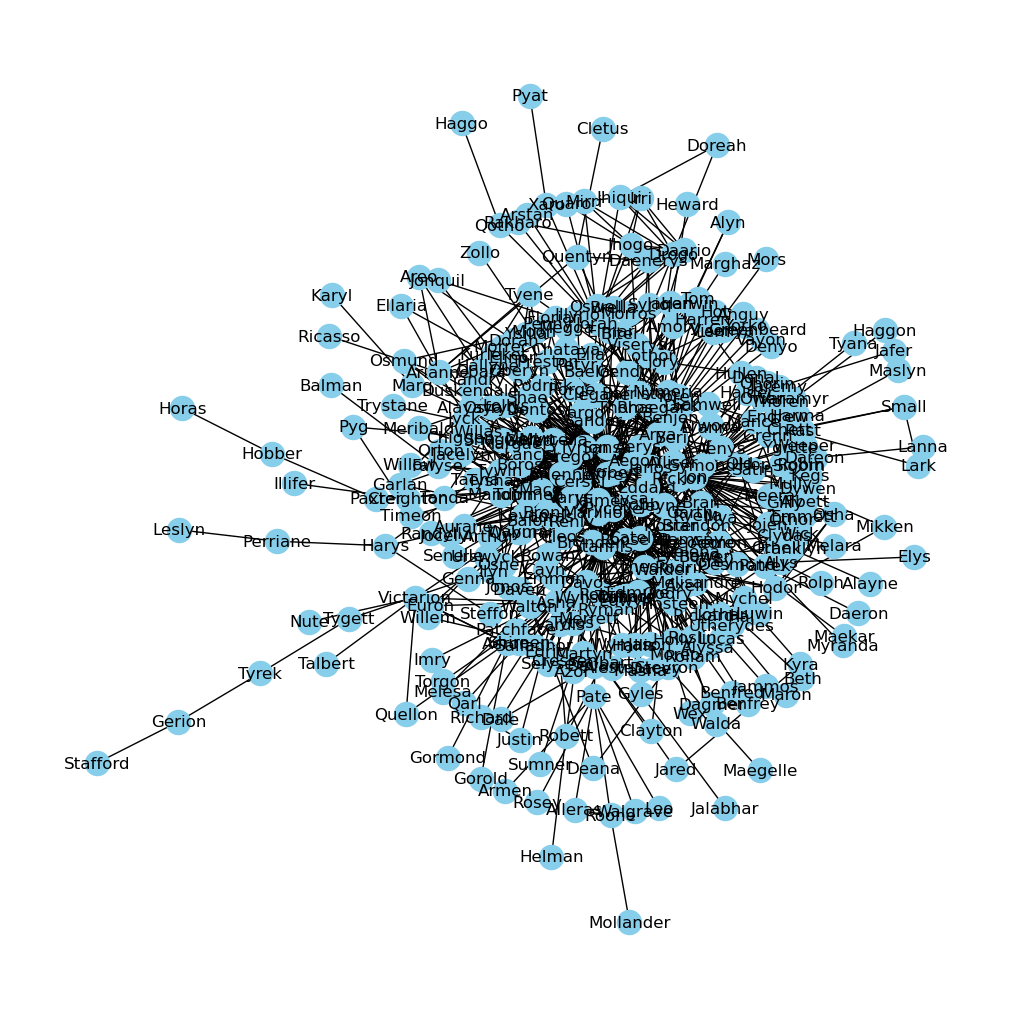

In [71]:
# Visuals using the top 500
plt.figure(figsize = (10,10))
G = nx.from_pandas_edgelist(top_500_df,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())

pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = "skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [72]:
# Visualize using Pyvis

from pyvis.network import Network

net = Network(notebook = True, width = "1000px", height = "700px", bgcolor = "#222222", font_color = "white")
net.repulsion()

node_degree = dict(G.degree)

nx.set_node_attributes(G, node_degree, 'size')
net.from_nx(G)
net.show("GoT.html")

GoT.html


<Axes: >

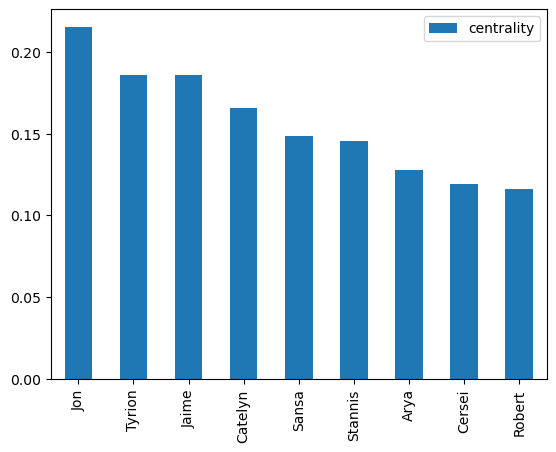

In [73]:
# Most important characters

# Degree centrality

degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame.from_dict(degree_dict, orient = 'index', columns = ['centrality'])
degree_df.sort_values('centrality', ascending = False)[0:9].plot(kind = "bar")

<Axes: >

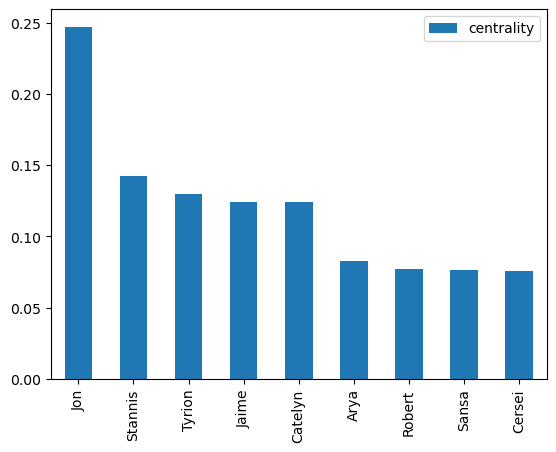

In [74]:
# Betweenness centrality

betweenness_dict = nx.betweenness_centrality(G)
degree_df = pd.DataFrame.from_dict(betweenness_dict, orient = 'index', columns = ['centrality'])
degree_df.sort_values('centrality', ascending = False)[0:9].plot(kind = "bar")

<Axes: >

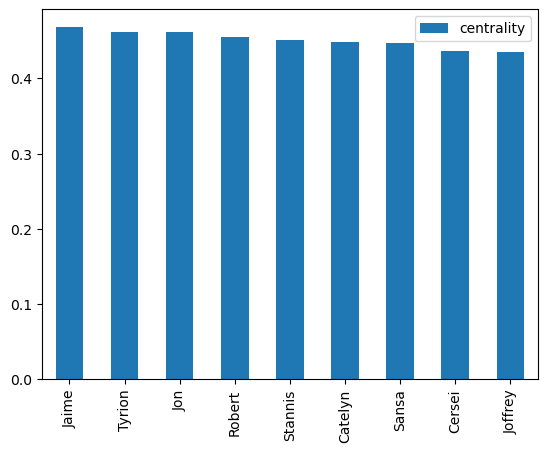

In [75]:
# Closeness centrality

closeness_dict = nx.closeness_centrality(G)
degree_df = pd.DataFrame.from_dict(closeness_dict, orient = 'index', columns = ['centrality'])
degree_df.sort_values('centrality', ascending = False)[0:9].plot(kind = "bar")

In [76]:
# Community Detection

import community as community_louvain

communities = community_louvain.best_partition(G)

In [77]:
# Save measures

nx.set_node_attributes(G, degree_dict, 'degree_centrality')
nx.set_node_attributes(G, betweenness_dict, 'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict, 'closeness_centrality')
nx.set_node_attributes(G, communities, 'group')

In [78]:
# Recreate the visual while accounting for communities

com_net = Network(notebook = True, width = "1000px", height = "700px", bgcolor = "#222222", font_color = "white")
com_net.from_nx(G)
com_net.repulsion()
com_net.show("GoT_communities.html")

GoT_communities.html


# Conclusions

### 1) Degree Centrality: Measures how many nodes each node is connected to. In other words, how many relationships each character has.
####  The top 5 characters in terms of centrality are: Jon, Tyrion, Jaime, Catelyn, and Sansa

### 2) Betweenness Centrality: Measures extent to which a node lies on the shortest paths between other nodes. A character with high betweenness has a greater effect on the flow of information through the network
####  The top 5 characters in terms of centrality are: Jon, Stannis, Tyrion, Jaime, Catelyn

### 3) Closeness Centrality: Measures how close a node is to all other nodes in the network. A character with high closeness has a greater chance to interact with characters they have not yet interacted with
####  The top 5 characters in terms of centrality are: Jaime, Tyrion, Jon, Robert, Stannis

# Shortcomings and Potential Improvements

#### 1) The text files that contain the books also include lots of text that is outside the main story line (prologue, epilogue, character info pages, etc).
######  A more thorough and detailed data cleaning process could help eliminate these pages by trimming the text files using proper parameters.

#### 2) Naming Conventions. The author of ASOIAF is well known for using the same name for many characters as well as giving characters nicknames
######  A prime example would be Daenerys Targaryen. She is often referred to as Khaleesi; however, in the character list we scraped, her name is Daenerys.
######  This would explain the reason she doesn't appear in this analysis as she only started getting called Daenerys when she travelled back to Westeros, which happens past the last book.
######  A potential fix would be to alter the character list after scraping it to accommodate for what we know would be major characters